In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

data_csv = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')

/tmp/ipykernel_25839/3508918189.py:8: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')


In [2]:
data_before_action = data_csv.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

# Liste des colonnes à conserver
variables_pertinentes = [
    'created_datetime','code', 'product_name', 'brands', 'categories', 'ingredients_text', 'additives_tags', 'nutrition_grade_fr',
    'energy_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g','fiber_100g','fat_100g', 'saturated-fat_100g',
    'alcohol_100g', 'countries_fr','potassium_100g','calcium_100g','vitamin-a_100g','vitamin-c_100g','vitamin-d_100g','cholesterol_100g','image_url'
]

start = time.time()
data = data_csv.drop([col for col in data_csv.columns if col not in variables_pertinentes], axis=1)
end = time.time()
print(f"Temps d'exécution de la méthode drop() : {end - start:.4f} secondes")

Le nombre de lignes data avant action est 320772
Temps d'exécution de la méthode drop() : 0.0359 secondes


In [3]:
#doublons
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

duplicates = data[data.duplicated(subset=['code'], keep=False)]
print(f'Le nombre de doublons est {duplicates.shape[0]}')

most_recent_duplicates = duplicates.sort_values(by='created_datetime',ascending=False).drop_duplicates(subset=['code'])
data = data.drop(most_recent_duplicates.index, errors='ignore')

print(f'Le nombre de lignes data après suppression des doublons est {data.shape[0]}, {data_before_action - data.shape[0]} ont été supprimés')

Le nombre de lignes data avant action est 320772
Le nombre de doublons est 245
Le nombre de lignes data après suppression des doublons est 320660, 112 ont été supprimés


Le nombre de lignes data avant action est 320660


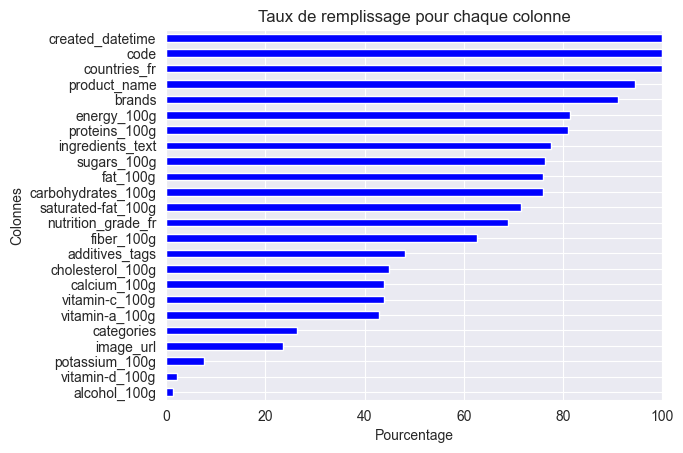

In [4]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')
#taux de remplissage des variables

missing_values = 100*(data[variables_pertinentes].notnull().mean())
missing_values = missing_values.sort_values(ascending=True)
missing_values.plot(kind='barh',title='Taux de remplissage pour chaque colonne', color='blue', xlim=[0,100])
plt.xlabel('Pourcentage')
plt.ylabel('Colonnes')
plt.show()

In [5]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

#La variables  code et product_name sont obligatoires
empty_mandatory_variables = data[
    (data['product_name'].isna()) | ((data['code'].isna()))
]
print(f'Les individus avec un nom de produit ou code vides sont aux nombre de {len(empty_mandatory_variables)}')
data.drop(empty_mandatory_variables.index, inplace=True)

#imputation par 0 pour les variables quantitatives
cols = ['potassium_100g','calcium_100g','vitamin-a_100g','vitamin-c_100g','vitamin-d_100g','cholesterol_100g','energy_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g','fiber_100g','fat_100g', 'saturated-fat_100g', 'alcohol_100g']
data[cols] = data[cols].fillna(0)

#les 7 lignes avec une valeur négative pour sugar semblent être une erreur de signe.
#Remplacement par la valeur absolue
print(data.loc[data['sugars_100g'] < 0, ['carbohydrates_100g','sugars_100g']])
data.loc[data['sugars_100g'] < 0,'sugars_100g'] = data['sugars_100g'].abs()

Le nombre de lignes data avant action est 320660
Les individus avec un nom de produit ou code vides sont aux nombre de 17780
        carbohydrates_100g  sugars_100g
8582                  3.61        -1.20
18209                 7.20        -0.80
117739               21.43        -3.57
146284               66.67        -6.67
150858                5.00        -6.25
164030               53.57       -17.86
195761                0.80        -0.10


Le nombre de lignes data avant action est 302880
<function show at 0x7efda0d360e0>


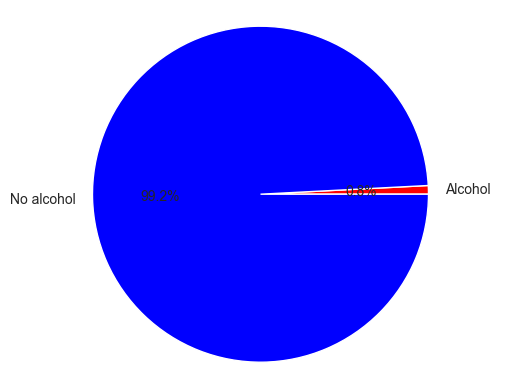

In [6]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

#Les produits contenant de l'alcool sont à bannir
data_alcohol = data[data['alcohol_100g'] > 0]
data_no_alcohol = data[data['alcohol_100g'] == 0]
percent_alcohol = len(data_alcohol) / len(data)
percent_no_alcohol = len(data_no_alcohol) / len(data)
labels = ['Alcohol', 'No alcohol']
sizes = [percent_alcohol, percent_no_alcohol]
colors = ['red', 'blue']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
ax.axis('equal')
print(plt.show)
indices_to_drop = data[data['alcohol_100g'] > 0].index
data = data.drop(indices_to_drop)

Le nombre de lignes data avant action est 300381
36417 produits ont été retirés


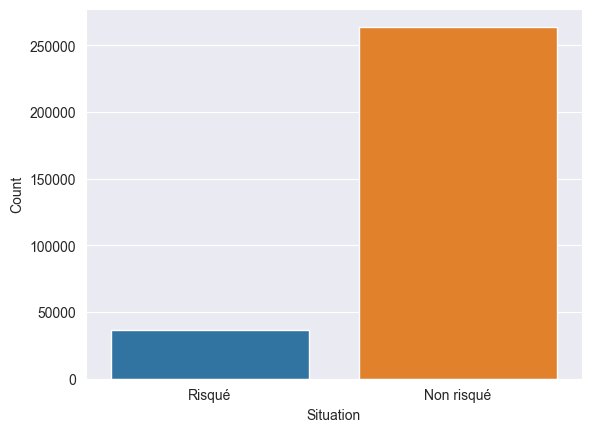

In [7]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

#les additifs
data.loc[data['additives_tags'].isnull(), 'additives_tags'] = ''
risky_additives = ['E250', 'E450', 'E202', 'E407', 'E252', 'E621', 'E224', 'E211', 'E482', 'E249', 'E212', 'E343',
                   'E1102', 'E511', 'E155']
risky_additives_regex = '|'.join(risky_additives)  # join the elements of the list with `|`
data['additives_tags_clean'] = data['additives_tags'].str.replace('en:', '')

# print(data.loc[40:55, 'additives_tags_clean'])
data['risky'] = 'non'
risky = data[data['additives_tags_clean'].str.contains(risky_additives_regex, case=False)]
data.loc[risky.index, 'risky'] = 'oui'

risky_count = len(data[data['risky'] == 'oui'])
non_risky_count = len(data[data['risky'] == 'non'])
# Créer un dataframe avec les données à afficher dans le graphique
risky_frame = pd.DataFrame({'Situation': ['Risqué', 'Non risqué'], 'Count': [risky_count, non_risky_count]})
sns.barplot(x='Situation', y='Count', data=risky_frame)

#retirer les aliments risqué
print(f'{risky_count} produits ont été retirés')
data.drop(data[data['risky'] == 'oui'].index, inplace=True)


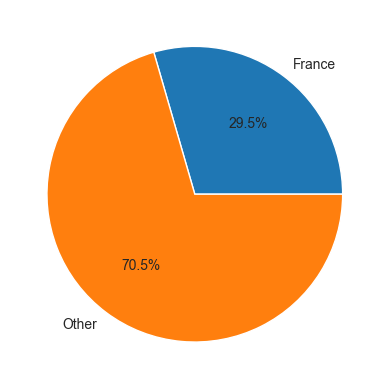

In [8]:
#répartition produits français
france_data = data[data['countries_fr'].str.contains('France', na=False)]
other_data = data[~data['countries_fr'].str.contains('France', na=False)]
france_percentage = len(france_data) / len(data) * 100
other_percentage = len(other_data) / len(data) * 100
plt.pie([france_percentage, other_percentage], labels=['France', 'Other'], autopct='%1.1f%%')
plt.show()


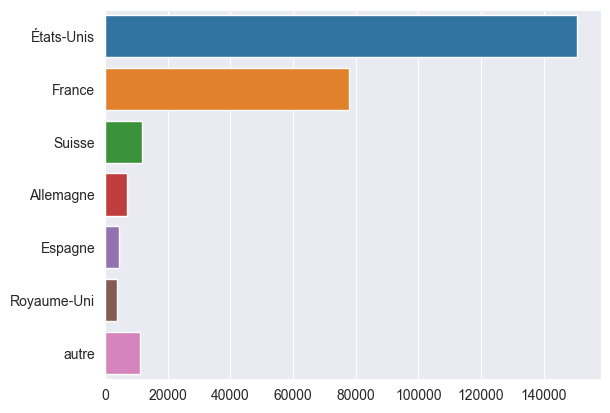

In [9]:
#répartition des produits par pays
pays = [
    "Afrique du Sud","Albanie","Algérie","Allemagne","Andorre","Angola","Arabie saoudite","Argentine","Arménie","Australie","Autriche","Azerbaïdjan",
    "Bahreïn","Bangladesh","Belgique","Belize","Bénin","Bhoutan","Biélorussie","Bolivie","Bosnie-Herzégovine","Botswana","Brésil","Brunei","Bulgarie","Burkina Faso","Burundi",
    "Cambodge","Cameroun","Canada","Cap-Vert","Chili","Chine","Chypre","Colombie","Comores","Congo","Corée du Nord","Corée du Sud","Costa Rica","Côte d'Ivoire","Croatie","Cuba",
    "Danemark","Djibouti","Dominique",
    "Égypte","Émirats arabes unis","Équateur","Érythrée","Espagne","Estonie","États-Unis","Éthiopie",
    "Fidji","Finlande","France",
    "Gabon","Gambie","Géorgie","Ghana","Grèce","Grenade","Guatemala","Guinée","Guinée-Bissau","Guinée équatoriale","Guyana",
    "Haïti","Honduras","Hong Kong","Hongrie",
    "Îles Marshall","Inde","Indonésie","Irak","Iran","Irlande","Islande","Israël","Italie",
    "Jamaïque","Japon","Jordanie",
    "Kazakhstan","Kenya","Kirghizistan","Kiribati","Koweït",
    "Laos","Lesotho","Lettonie","Liban","Liberia","Libye","Liechten","Liban","Lituanie","Luxembourg",
    "Malaisie","Malawi", "Mali", "Malte", "Maroc", "Maurice", "Mauritanie", "Mexique", "Moldavie", "Monaco","Mongolie", "Monténégro",
    "Nigeria", "Norvège", "Nouvelle-Calédonie", "Nouvelle-Zélande",
    "Oman",
    "Pays-Bas", "Pérou", "Philippines", "Pologne", "Portugal",
    "Qatar",
    "Roumanie", "Royaume-Uni", "République centrafricaine", "République dominicaine", "République tchèque",
    "Salvador", "Serbie", "Singapour", "Slovaquie", "Slovénie", "Suède",    "Suisse",
    "Taiwan", "Tanzanie", "Thaïlande", "Togo", "Tunisie", "Turquie",
    "Ukraine",
    "Venezuela", "Viêt Nam",
    "Yémen",
    "Zambie", "Zimbabwe"
]

data['countries_split'] = data['countries_fr'].str.split(',')
countries_series = data['countries_split'].explode().value_counts()
filtered_series = countries_series[countries_series.index.isin(pays)]

seuil = 3000
pays = filtered_series.loc[filtered_series >= seuil]
autre = pd.Series([filtered_series.loc[filtered_series < seuil].sum()], index=['autre'])
reordered_series =  pd.concat([pays, autre])

sns.barplot(x=reordered_series.values, y=reordered_series.index)
plt.show()

Le nombre de lignes data avant action est 263964


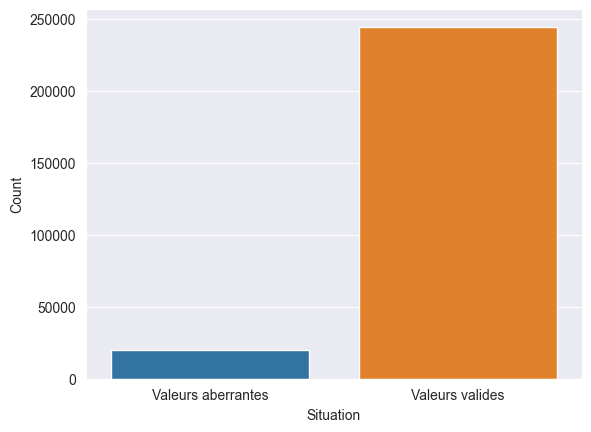

In [10]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

#enlever les valeurs non numériques aberrantes
list = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
for v in list:
    data[v] = pd.to_numeric(data[v], errors='coerce')
    data.loc[data[v].isnull(), v] = 0
    data.loc[data[v] > 100, v] = 100

#les valeurs énergétiques sont aberrantes si les graisses saturées > aux graisses, si les sucres > carbohydrates et si la somme des carbohydrates, protéines et lipides dépassent 100g
aberrants = data[(data['saturated-fat_100g'] > data['fat_100g']) |
                 (data['sugars_100g'] > data['carbohydrates_100g']) |
                 (data['carbohydrates_100g'] + data['proteins_100g'] + data['fat_100g'] > 100)]

aberrants_count = len(aberrants)

aberrants_frame = pd.DataFrame(
    {'Situation': ['Valeurs aberrantes', 'Valeurs valides'], 'Count': [aberrants_count, len(data) - aberrants_count]})
sns.barplot(x='Situation', y='Count', data=aberrants_frame)
#suppression des valeurs aberrantes
data.drop(aberrants.index, inplace=True)

In [11]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

#Valeur aberrantes énergétiques: création d'une colonne supplémentaire avec le bon calcul énergétique
kcal_prot = 4
kcal_glucide = 4
kcal_lipide = 9
data['kcal'] = (data['proteins_100g'] * kcal_prot + data['carbohydrates_100g'] * kcal_glucide + data['fat_100g'] * kcal_lipide)
# #Suppression des valeurs énergétiques <= 0 ou > 900
mask = ((data['kcal'] <= 0) | (data['kcal'] > 900 ))
print(f'Les lignes <= 0 sont au nombre de {(data["kcal"] <= 0).sum()}')
print(f'Les lignes > 900 sont au nombre de {(data["kcal"] > 900).sum()}')
data.drop(data[mask].index, inplace=True)


Le nombre de lignes data avant action est 244346
Les lignes <= 0 sont au nombre de 47833
Les lignes > 900 sont au nombre de 0


Le nombre de lignes data avant action est 196513
Le nombre de lignes < 100 calories 141208
Le nombre de lignes > 900 calories 0


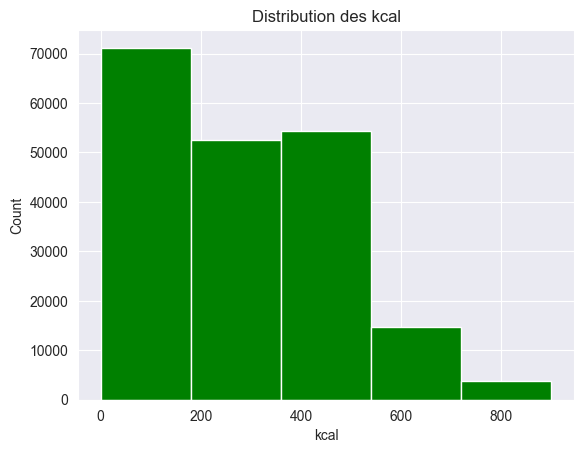

In [12]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

# (Distribution du nombre de produits par tranche d'énergie)
bins = 5

# # Plot the histogram
data['kcal'].hist(bins=bins, rwidth=1, color='g')

# # Add axis labels and plot title
plt.xlabel("kcal")
plt.ylabel("Count")
plt.title("Distribution des kcal")
plt.show()

Médiane des calories 291.3
Mode des calories 0    400.0
Name: kcal, dtype: float64
Moyenne des calories 284.3590591207553
Variance 37693.03515581054
Ecart type 194.14743615654262


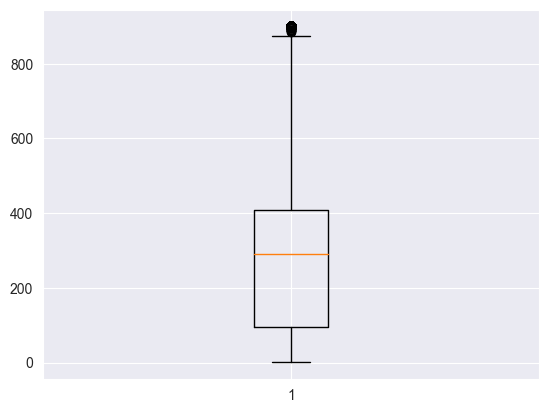

In [13]:
# Créer un diagramme en boîte à moustache pour les calories
plt.boxplot(data["kcal"])
print(f'Médiane des calories {data["kcal"].median()}')
print(f'Mode des calories {data["kcal"].mode()}')
print(f'Moyenne des calories {data["kcal"].mean()}')
print(f'Variance {data["kcal"].var(ddof=0)}')
print(f'Ecart type {data["kcal"].std()}')

# on constate que la médiane est proche de la moyenne ce qui témoigne d'une répartition assez équilibrée, et les outliers ne perturbent pas la moyenne

Le nombre de lignes data avant action est 196513


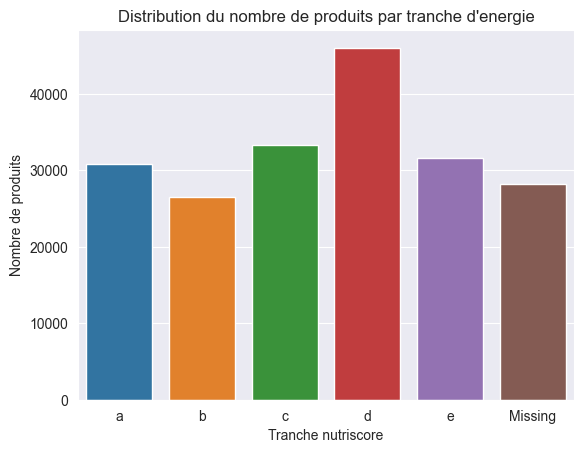

d          46041
c          33286
e          31665
a          30772
Missing    28190
b          26559
Name: nutrition_grade_fr, dtype: int64


In [14]:
data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

#distribution produits par nutriscore
# Countplot with the order specified
# Fill the missing values with 'Missing'
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].fillna('Missing')
order = ['a','b','c','d','e','Missing']
sns.countplot(x='nutrition_grade_fr', data=data, order=order)

# Set the plot's title and axis labels
plt.title("Distribution du nombre de produits par tranche d'energie")
plt.xlabel("Tranche nutriscore")
plt.ylabel("Nombre de produits")
# Display the plot
plt.show()
# Print the counts of each value
print(data['nutrition_grade_fr'].value_counts())

In [15]:
# calculer le nutriscore pour les valeurs vides (en moyenne)
def calcul_nutriscore(line):
    A = -0.6 #moyenne des possibilités
    B = 3
    C = 2
    D = 1
    E = 0.35 #moyenne des possibilités
    nutriscore = (A * (2 * line['kcal'] / 100) + B * (line['sugars_100g'] / 100) + C * (line['saturated-fat_100g'] / 100) - D * (line['fiber_100g'] / 100) - E * (line['proteins_100g'] / 100))
    if nutriscore < -2:
        nutriscore_letter = 'a'
    elif nutriscore < -1:
        nutriscore_letter = 'b'
    elif nutriscore < 1:
        nutriscore_letter = 'c'
    elif nutriscore < 3:
        nutriscore_letter = 'd'
    else:
        nutriscore_letter = 'e'
    return  nutriscore_letter

data['sugars_100g'].fillna(0, inplace=True)
data['saturated-fat_100g'].fillna(0, inplace=True)
data['fiber_100g'].fillna(0, inplace=True)
data['proteins_100g'].fillna(0, inplace=True)
data.loc[(data['nutrition_grade_fr'] =='Missing'), 'nutrition_grade_fr'] = data.loc[(data['nutrition_grade_fr'] =='Missing'), ['kcal','sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'proteins_100g']].apply(calcul_nutriscore, axis=1)


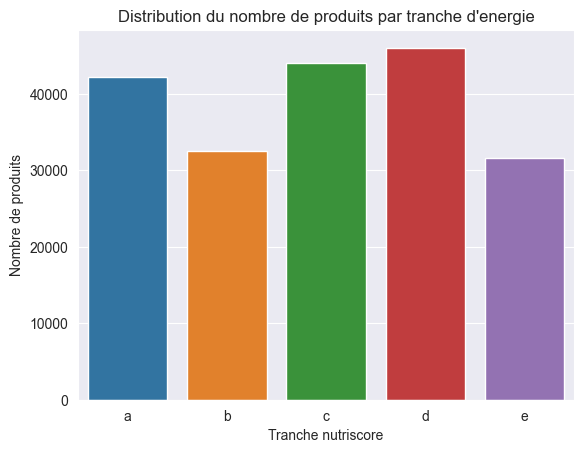

d    46041
c    44086
a    42234
b    32487
e    31665
Name: nutrition_grade_fr, dtype: int64
Mode nutri 0    d
Name: nutrition_grade_fr, dtype: object


In [16]:
order = ['a','b','c','d','e']
sns.countplot(x='nutrition_grade_fr', data=data, order=order)

# Set the plot's title and axis labels
plt.title("Distribution du nombre de produits par tranche d'energie")
plt.xlabel("Tranche nutriscore")
plt.ylabel("Nombre de produits")
# Display the plot
plt.show()
# Print the counts of each value
print(data['nutrition_grade_fr'].value_counts())
print(f'Mode nutri {data["nutrition_grade_fr"].mode()}')

# l'imputation par le calcul du nutriscore joue en faveur de la note A, mais il faut garder en tête que les valeurs manquantes
# à 35% pour les sucres et les graisses saturées peuvent expliquer cela

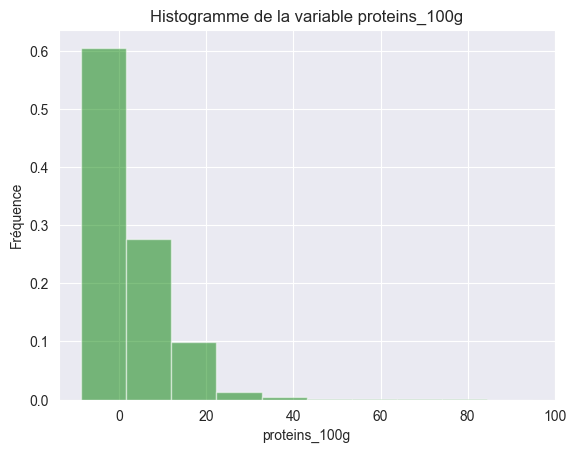

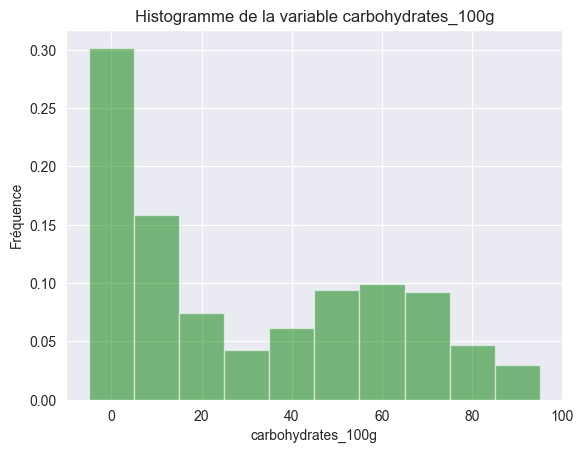

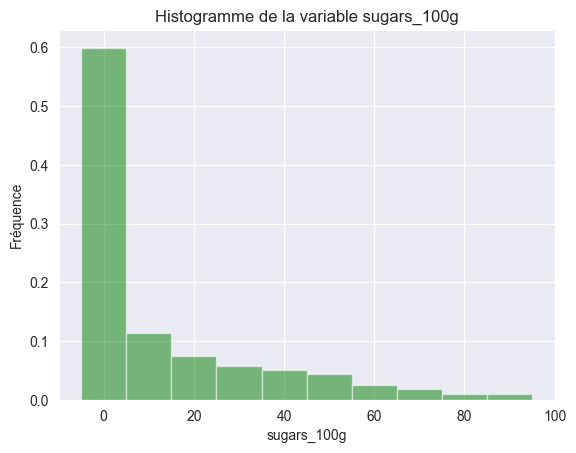

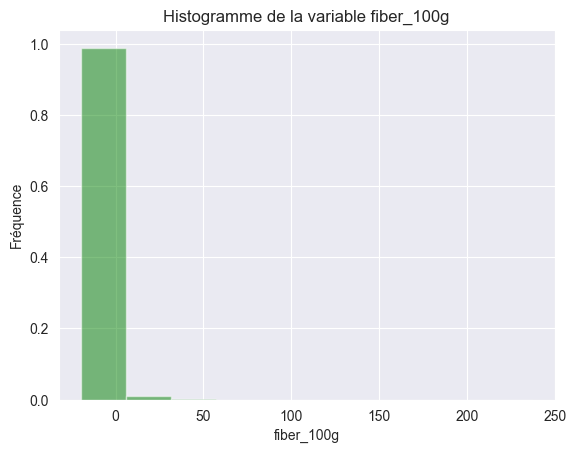

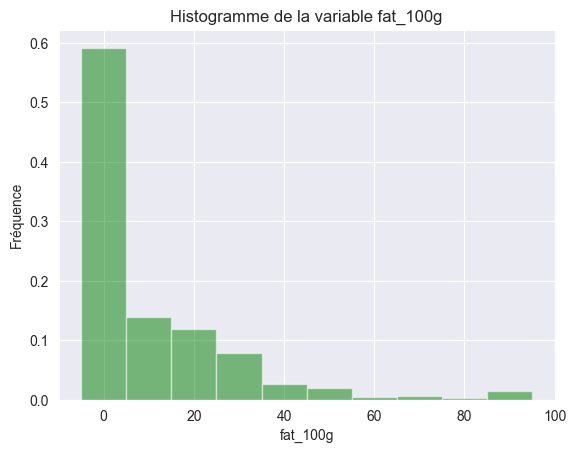

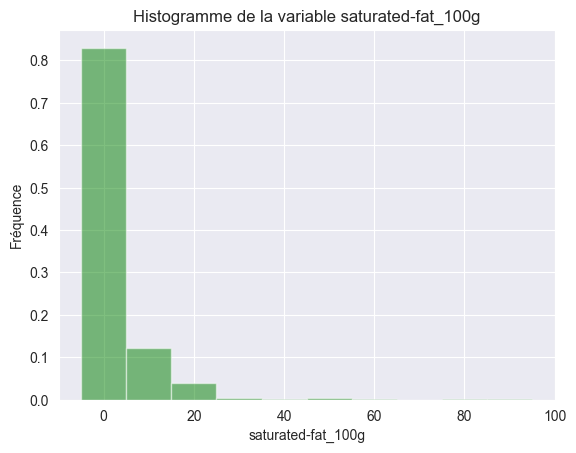

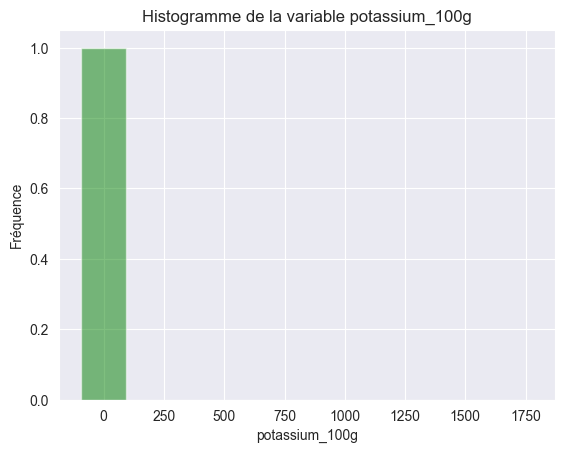

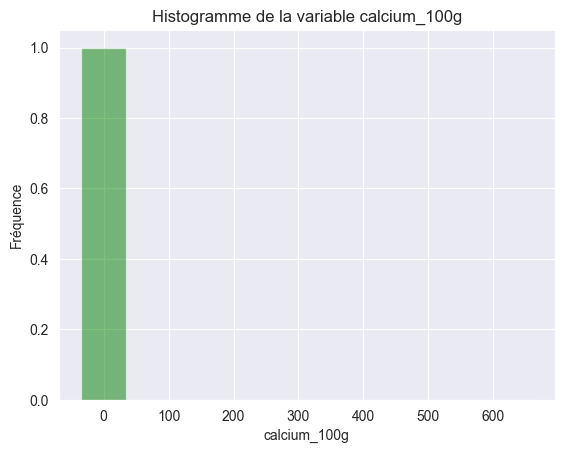

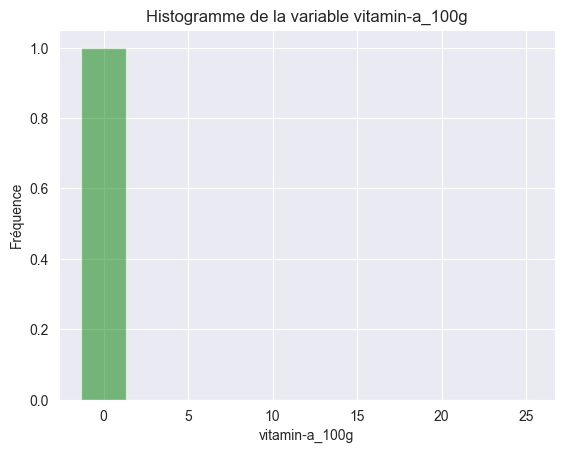

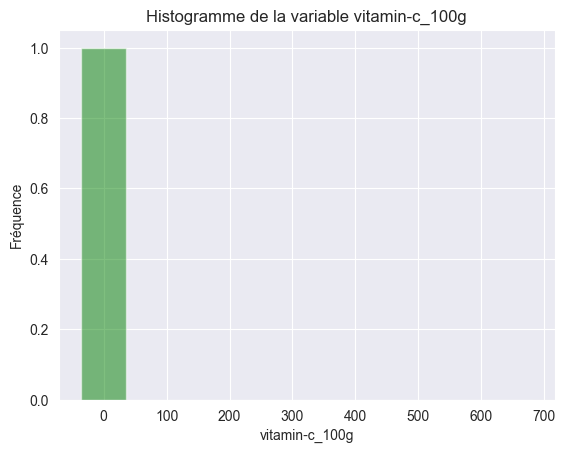

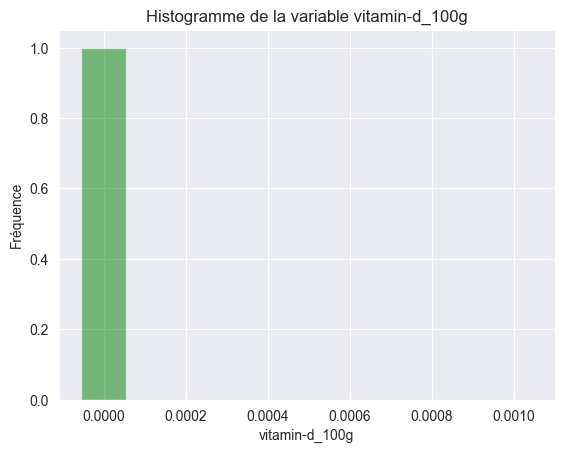

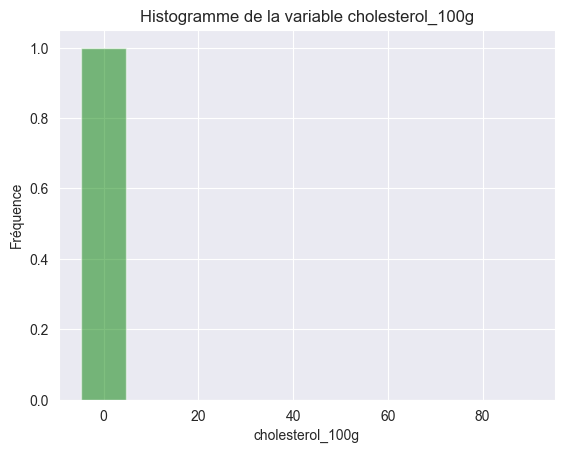

In [17]:
# Création des tranches pour l'histogramme
#Liste de variables quantitatives
quant_vars = ['proteins_100g', 'carbohydrates_100g', 'sugars_100g','fiber_100g','fat_100g', 'saturated-fat_100g', 'potassium_100g','calcium_100g','vitamin-a_100g','vitamin-c_100g','vitamin-d_100g','cholesterol_100g']

# Boucle à travers les variables quantitatives
for var in quant_vars:
    # Calcule les effectifs, les fréquences, les fréquences cumulées
    counts, bin_edges = np.histogram(data[var], bins = 10, density = False)
    freqs = counts / len(data[var])
    cdf = np.cumsum(freqs)

    # Tracer l'histogramme
    plt.bar(bin_edges[:-1], freqs, width = bin_edges[1] - bin_edges[0], color = 'g', alpha = 0.5)
    plt.xlabel(var)
    plt.ylabel("Fréquence")
    plt.title("Histogramme de la variable "+ var)
    plt.show()


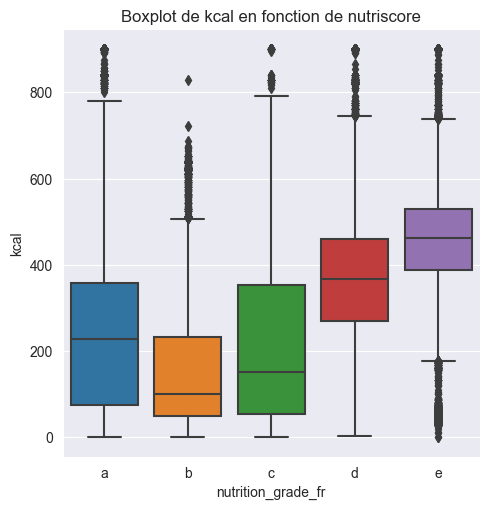

In [18]:
#  une hypothèse pourrait être que plus les calories d'un produit alimentaire sont élevées, plus il y a de chances que son nutriscore soit faible. Cela s'appuie sur l'idée que les produits alimentaires riches en calories ont tendance à être plus riches en matières grasses, sucres etc  ..
# Utiliser la fonction boxplot de seaborn pour créer un boxplot pour chaque niveau de nutriscore
sns.catplot(x="nutrition_grade_fr", y="kcal", data=data, kind="box", order=["a", "b", "c", "d", "e"])

plt.title("Boxplot de kcal en fonction de nutriscore")
plt.show()

#on rappelle que les meilleures notes sont probablement tirées vers le haut dû au valeurs manquantes à 35% des sucres et 35% des graisses saturées.
# partant de là, on peut observer une relation assez linéaire qui pourrait appuyer l'hypothèse. Des tests statistiques doivent être faits.
#on note aussi une plus forte dispersion autour de la médiane pour les notes A et C comparées aux autres

In [19]:
# Mapping des valeurs qualitatives ordinales
map_dict = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5}
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].replace({'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5})

# calcul de la correlation
# coefficient de correlation = covar(x,y)/sx*sy
# covar(x,y) = 1/n * Σ((x_i - x̄) * (y_i - ȳ))


covar_x_y = data['kcal'].cov(data['nutrition_grade_fr'])
sx = data['kcal'].std()
sy = data['nutrition_grade_fr'].std()
ro_x_y = covar_x_y / sx * sy
ro_x_y

#spearman donne une corrélation à 0.46 vs 0.78 pour le calcul de corrélation normalisé
# corr, p_value = spearmanr(data['kcal'], data['nutrition_grade_fr'])
# print("Correlation coefficient: ", corr)
# print("p-value: ", p_value)

# Le coefficient de corrélation est de 0.46 indique une corrélation positive modérée.
#La p-value de 0.0 est inférieure à 0.05, il y a une corrélation  significative


0.788291379323837